In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Load Data from Directory

We load data from directory using `tf.data` and split into training and validation subset.


In [2]:

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32

TRAIN_DIR = "E:/Datasets/IntelEnv/seg_train/seg_train"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15,
    subset='training',
    seed=124,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15,
    subset='validation',
    seed=124,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

class_names = train_data.class_names

Found 14034 files belonging to 6 classes.
Using 11929 files for training.
Found 14034 files belonging to 6 classes.
Using 2105 files for validation.


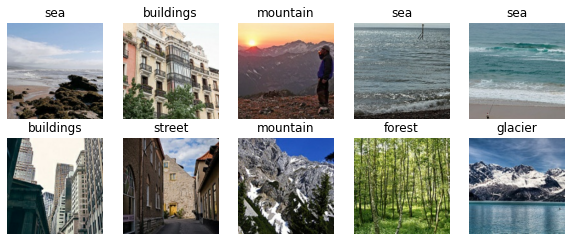

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Preprocess

Preprocess input and configure dataset for performance

# Using Efficient Net

### Define Image augmentation layers

We augment data to create multiple images for a image for better training

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

### Intialize
Intialize using input layer and image size. Then for next layer we use augmentation layer that we created above

In [5]:
inputs = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = img_augmentation(inputs)

### Load Efficient Net Model

You can replace `EfficientNetB0` with any model of your choice

In [6]:
model = tf.keras.applications.EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet")

In [7]:
# Freeze the pretrained weights
model.trainable = False

In [8]:
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)


outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="pred")(x)

### Compile Model

We will use tf keras to build a model and then compile using adam optimizer and categorical cross entropy loss

In [9]:
# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [10]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
_______________________________________________________________________________________

In [11]:
epochs = 25  
hist = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)

Epoch 1/25
373/373 - 128s - loss: 0.5681 - accuracy: 0.7956 - val_loss: 0.2972 - val_accuracy: 0.8836
Epoch 2/25
373/373 - 109s - loss: 0.4391 - accuracy: 0.8421 - val_loss: 0.2834 - val_accuracy: 0.8903
Epoch 3/25
373/373 - 111s - loss: 0.4140 - accuracy: 0.8487 - val_loss: 0.2822 - val_accuracy: 0.8893
Epoch 4/25
373/373 - 112s - loss: 0.4020 - accuracy: 0.8515 - val_loss: 0.2659 - val_accuracy: 0.8983
Epoch 5/25
373/373 - 110s - loss: 0.3918 - accuracy: 0.8566 - val_loss: 0.2533 - val_accuracy: 0.9135
Epoch 6/25
373/373 - 108s - loss: 0.3924 - accuracy: 0.8586 - val_loss: 0.2726 - val_accuracy: 0.9017
Epoch 7/25
373/373 - 108s - loss: 0.3722 - accuracy: 0.8597 - val_loss: 0.2598 - val_accuracy: 0.9031
Epoch 8/25
373/373 - 108s - loss: 0.3715 - accuracy: 0.8681 - val_loss: 0.2661 - val_accuracy: 0.8964
Epoch 9/25
373/373 - 107s - loss: 0.3618 - accuracy: 0.8697 - val_loss: 0.2454 - val_accuracy: 0.9074
Epoch 10/25
373/373 - 107s - loss: 0.3530 - accuracy: 0.8727 - val_loss: 0.2616 - 

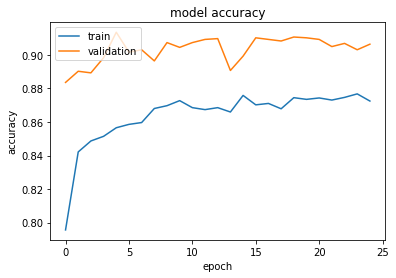

In [12]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

